Code for importing the data, we already have the pickles, so we can skip this part. Go straight ahead to loading pickled data. 

In [35]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import wandb
from tqdm import tqdm
import numpy as np

sweep_ids = ["br7d1x52"]
kernel = "Matern52"
dimension = 1
api = wandb.Api(timeout=290)


def fetch_config_and_metrics(run):
    try:
        # metric_keys = ["Regret-Gap acq"]
        metric_keys = ["cumulative cost", "best observed", "regret", "StablePBGI(0.1)", "StablePBGI(0.01)", "StablePBGI(0.001)", "LogEIC acq", "UCB-LCB acq", "Regret-Gap acq", 'PRB_0.1'] 
        summary_keys = ["global optimum value"]

        hist = run.scan_history(keys=metric_keys, page_size=1000)
        metrics = {k: [] for k in metric_keys}
        for row in hist:
            for k in metric_keys:
                if k in row:
                    metrics[k].append(row[k])

        summary_hist = run.scan_history(keys=summary_keys, page_size=1000)
        for k in summary_keys:
            metrics[k] = [row[k] for row in summary_hist if k in row]

        return (run.config, metrics)
    except Exception as e:
        print(f"[WARN] Failed on run {run.id}: {e}")
        return None

def load_impact_of_lmbda_runs(acq, lengthscale, cost_type):
    runs = api.runs(path="ziv-scully-group/StoppingBayesOptSynthetic", filters={
        "sweep": {"$in": sweep_ids},
        "config.amplitude": 1,
        "config.dim": dimension,
        "config.kernel": kernel,
        "config.lengthscale": lengthscale,
        "config.policy": acq,
        "config.cost": cost_type})

    runs = list(runs)  # force evaluation
    print (acq, lengthscale, cost_type) 
    print( "number of runs: ", len(runs))
    if len(runs) == 0:
        print(f"No runs found for acq: {acq}, lengthscale: {lengthscale}, cost_type: {cost_type}")
        return []
    max_workers = min(8, len(runs))  # adjust as needed
    
    configs_and_metrics = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(fetch_config_and_metrics, run) for run in runs]
        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            if result is not None:
                configs_and_metrics.append(result)
    print (configs_and_metrics)
    return configs_and_metrics

In [36]:
acquisition_functions = [
    'ThompsonSampling',
    'Stable_Gittins_Lambda_1',
    'Stable_Gittins_Lambda_01',
    'Stable_Gittins_Lambda_001',
    'LogEIWithCost', 
    'UpperConfidenceBound', 
]
lengthscales = [0.1]
# lengthscales = [0.05, 0.1, 0.2, 0.5]
# cost_type = ['uniform']
cost_type = ['uniform', 'linear', 'periodic']

In [ ]:
grouped_runs = {(a, l, c): load_impact_of_lmbda_runs(a, l, c) for a in acquisition_functions for l in lengthscales for c in cost_type}

In [ ]:
from collections import defaultdict
import numpy as np


from collections import defaultdict

def nested_defaultdict():
    return defaultdict(dict)

metrics_per_acq = defaultdict(nested_defaultdict)

for a in acquisition_functions:
    for l in lengthscales:
        for c in cost_type:
            setting = (a, l, c)
            config_and_metrics_per_seed = grouped_runs[setting]

            # Extract metrics along with the seeds for sorting, ignoring invalid inputs 
            seeds_and_metrics = [
                (
                    config['seed'],
                    m['cumulative cost'],
                    m['best observed'],
                    m['regret'],
                    m['StablePBGI(0.1)'],
                    m['StablePBGI(0.01)'],
                    m['StablePBGI(0.001)'],
                    m['LogEIC acq'], 
                    m['UCB-LCB acq'], 
                    m['Regret-Gap acq'], 
                    m['PRB_0.1']
                )
                for config, m in config_and_metrics_per_seed
                if len(m['best observed']) > 0
            ]

            # Sort by seed
            seeds_and_metrics.sort(key=lambda x: x[0])

            # Extract sorted metrics
            metric_keys = [
                "cumulative cost",
                "best observed",
                "regret", 
                "StablePBGI(0.1) acq",
                "StablePBGI(0.01) acq",
                "StablePBGI(0.001) acq",
                "LogEIC acq", 
                "UCB-LCB acq", 
                "Regret-Gap acq", 
                "PRB_0.1"
            ]

            arrays = [
                np.array([item[i + 1] for item in seeds_and_metrics], dtype=int if "id" in key else float)
                for i, key in enumerate(metric_keys)
            ]

            print(setting, arrays[1].shape)  # config_id is arrays[1]

            for key, array in zip(metric_keys, arrays):
                metrics_per_acq[setting][key] = array

In [ ]:
import pickle
import os

import dill
# Save processed metrics to disk
save_path = f'data/synthetic_1d_{kernel}_{sweep_ids[0]}.pkl'
with open(save_path, "wb") as f:
    dill.dump(metrics_per_acq, f)
print(f"Saved metrics_per_acq to {save_path}")

Start loading data and plotting here! 

In [53]:
import dill
kernel = "Matern52"
sweep_ids = ["br7d1x52"]
save_path = f'data/synthetic_1d_{kernel}_{sweep_ids[0]}.pkl'

with open(save_path, "rb") as f:
    metrics_per_acq = dill.load(f)

Here are some helper functions for computing statistics on stopping time and cost-adjusted simple regret 

In [54]:
def mean_and_std(data, num_samples, axis=0):
    return np.mean(data, axis=axis), np.std(data, axis=axis) /np.sqrt(num_samples)

In [55]:
import numpy as np
import torch
import math

def return_stopping_indices(
    best_obs_seed: np.ndarray,
    LogEIC_seed: np.ndarray,
    UCB_LCB_seed: np.ndarray,
    PRB_seed: np.ndarray,
    RegretGap_seed: np.ndarray,
    lmbda: float,
    max_iter: int,
    ucb_lcb_threshold: float = 0.01,
    delta: float = 0.05,
    convergence_window: int = 5,
    gss_window: int = 5,
    gss_frac: float = 0.01, 
    eta: float = 0.01,
    T_init: int = 20
) -> dict:
    """
    Compute the stopping index for various stopping rules for a single seed run.

    Parameters:
    - best_obs_seed: 1D array of best observed values per iteration.
    - LogEIC_seed: 1D array of LogEIC acquisition values.
    - UCB_LCB_seed: 1D array of (UCB - LCB) values.
    - PRB_seed: 1D array of PRB values.
    - RegretGap_seed: 1D array of Regret-Gap values.
    - lmbda: lambda value for LogEIC threshold.
    - max_iter: maximum number of iterations (iteration cutoff).
    - ucb_lcb_threshold: threshold for UCB-LCB stopping.
    - delta: parameter for PRB stopping (stop when PRB > 1 - delta).
    - convergence_window: number of consecutive iterations with no change in best observed.
    - gss_window: number of past trials to consider for GSS rule.
    - gss_frac: fraction of IQR to use as improvement threshold (e.g., 0.01 for 1%).

    Returns:
    - dict mapping stopping rule names to the stopping iteration index.
    """
    valid = {}

    # LogEIC: stop when LogEIC < log(lambda)
    valid['LogEIC'] = np.where(LogEIC_seed <= np.log(lmbda))[0]
   
    # UCB-LCB: stop when (UCB-LCB) < threshold
    valid['UCB-LCB'] = np.where(UCB_LCB_seed < ucb_lcb_threshold)[0]
    
    # PRB: stop when PRB > 1 - delta
    valid['PRB_0_1'] = np.where(PRB_seed > 1 - delta)[0]
    
    # SRGap-med: stop when regret-gap < eta * median of initial T_init gap values
    if len(RegretGap_seed) > T_init:
        median_initial = np.nanmedian(RegretGap_seed[1:T_init+1])
        # print(median_initial)
        threshold = eta * median_initial
        # print(threshold)
        valid['SRGap-med'] = np.where(RegretGap_seed < threshold)[0]
    else:
        valid['SRGap-med'] = np.array([], dtype=int)
    
    # SRGap-med: stop when LogEIC < eta * median of initial T_init LogEIC values
    if len(LogEIC_seed) > T_init:
        median_initial = np.nanmedian(LogEIC_seed[1:T_init+1])
        # print(median_initial)
        threshold = np.log(eta) + median_initial
        # print(threshold)
        valid['LogEIC-med'] = np.where(LogEIC_seed < threshold)[0]
    else:
        valid['LogEIC-med'] = np.array([], dtype=int)

    # Convergence: best observed unchanged for `convergence_window` iterations
    if len(best_obs_seed) > convergence_window:
        diffs = np.diff(best_obs_seed) == 0
        window = np.ones(convergence_window - 1, dtype=int)
        run_lengths = np.convolve(diffs.astype(int), window, mode='valid')
        conv_candidates = np.where(run_lengths == (convergence_window - 1))[0]
        if conv_candidates.size > 0:
            valid['Convergence'] = np.array([conv_candidates[0] + convergence_window - 1])
        else:
            valid['Convergence'] = np.array([], dtype=int)
    else:
        valid['Convergence'] = np.array([], dtype=int)

    # GSS: stop if improvement over past `gss_window` iters < `gss_frac` of current IQR
    valid['GSS'] = np.array([], dtype=int)
    if len(best_obs_seed) > gss_window:
        for i in range(gss_window, len(best_obs_seed)):
            past_best = best_obs_seed[i - gss_window]
            curr_best = best_obs_seed[i]
            improvement = curr_best - past_best  # assumes maximization
            # Compute IQR of best_obs_seed up to i (inclusive)
            window_vals = best_obs_seed[:i+1]
            q75, q25 = np.percentile(window_vals, [75, 25])
            iqr = q75 - q25
            if iqr <= 0:
                continue
            if improvement < gss_frac * iqr:
                valid['GSS'] = np.array([i])
                break

    # Select first valid index or fall back to max_iter - 1
    stopping_indices = {}
    for rule, inds in valid.items():
        stopping_indices[rule] = int(inds[0]) if inds.size > 0 else (max_iter - 1)
    # print("earliest EIC stopping time", stopping_indices['LogEIC'])
    return stopping_indices

Setting the style and font of the plots, as well as some initial parameters.  

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.4
})

plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    # 'xtick.rotation': 45,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.autolayout': False,  # we’ll call tight_layout() explicitly
})

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.ticker as ticker

# your existing lists
acquisition_functions = [
    'ThompsonSampling',
    'Stable_Gittins_Lambda_1',
    'Stable_Gittins_Lambda_01',
    'Stable_Gittins_Lambda_001',
    'LogEIWithCost', 
    'UpperConfidenceBound', 
]
acq_col_idxs = {
    'Stable_Gittins_Lambda_1':1,
    'Stable_Gittins_Lambda_01':1,
    'Stable_Gittins_Lambda_001':1,
    'LogEIWithCost':0, 
    'UpperConfidenceBound':2, 
    'ThompsonSampling':3
}

name_dict = {
    0.1: "λ = 0.1",
    0.01: "λ = 0.01",
    0.001: "λ = 0.001", 
    'Stable_Gittins_Lambda_1': "PBGI(0.1)",
    'Stable_Gittins_Lambda_01': "PBGI(0.01)",
    'Stable_Gittins_Lambda_001':"PBGI(0.001)",
    'LogEIWithCost':"LogEIC", 
    'UpperConfidenceBound': "LCB", 
    'ThompsonSampling': "TS", 
    'PRB_0_1': "PRB",
    'LogEIC': "PBGI/LogEIC",
    'LogEIC-med':"LogEIC-med", 
    'UCB-LCB': "UCB-LCB",
    'Convergence': "Convergence",
    'GSS': "GSS",
    'SRGap-med':"SRGap-med",
    'uniform': "Uniform Cost",
    'linear': "Linear Cost",
    'periodic': "Periodic Cost" 
}
lmbda_to_str = {
    0.1:'1',
    0.01:'01',
    0.001: '001'
}

color_dict = {
    'LogEIC':                  'tab:orange',
    'LogEIWithCost':           'tab:blue',
    'LogEIC-med':              'tab:blue',
    'Stable_Gittins_Lambda_1': 'tab:orange',
    'Stable_Gittins_Lambda_01':'tab:orange',
    'Stable_Gittins_Lambda_001':'tab:orange',
    'UpperConfidenceBound':    'tab:purple',
    'UCB-LCB':                 'tab:purple',
    'SRGap-med':               'tab:pink',
    'ThompsonSampling':        'tab:brown',
    'PRB_0_1':                 'tab:brown',
    'GSS':                     'tab:olive',
    'Convergence':             'tab:gray',
    'Hindsight':               'tab:red'
}
marker_dict = {
    0.1: 'o',
    0.01: '^',
    0.001: 's'
}

lengthscales = [0.1]
# lengthscales = [0.05, 0.1, 0.2, 0.5]
# cost_type = ['uniform']
cost_type = ['uniform', 'linear', 'periodic']
# lambda_per_acq = [0.1, 0.01, 0.001]
lambda_per_acq = [0.1, 0.01, 0.001]
lengthscales = [0.1]
# --- stopping‐rule parameters ---
delta = 0.05                        # for PRB: stop when P(success) > 1 – delta
ucb_lcb_threshold = 0.01           # for UCB–LCB: stop when (UCB – LCB) < threshold
convergence_window = 5
gss_window = 5 
gss_frac = 0.01             

# 'SRGap-med'
stopping_rules = [
    'LogEIC',
    'LogEIC-med',
    'SRGap-med',
    'UCB-LCB',
    'PRB_0_1',
    'GSS',
    'Convergence'
]

iteration_cutoff = {}
iteration_cutoff[0.1]= 100
iteration_cutoff[0.01]= 100
iteration_cutoff[0.001]= 100

Plots: iteration vs cost adjusted regret. 

limits: 0.27520149356236756, 9.977960038066389
limits: 0.21038734126040162, 9.54329959423873
limits: 0.37513227524728376, 30.03641136345813


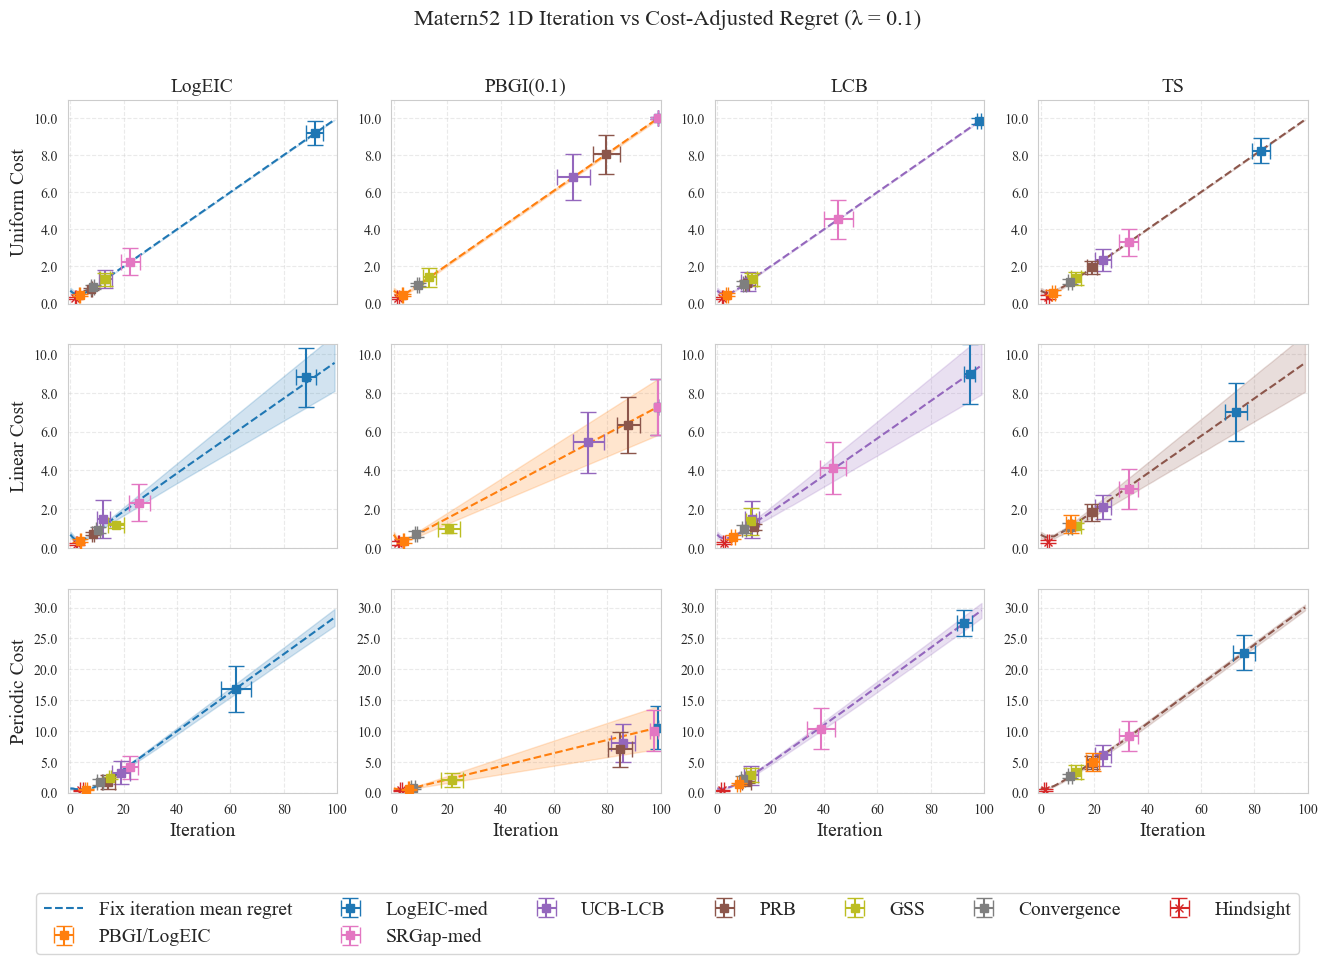

limits: 0.04326764403234715, 0.9908863141880312
limits: 0.03602739573627227, 0.9551667578750928
limits: 0.07575419011462567, 3.00364100230353


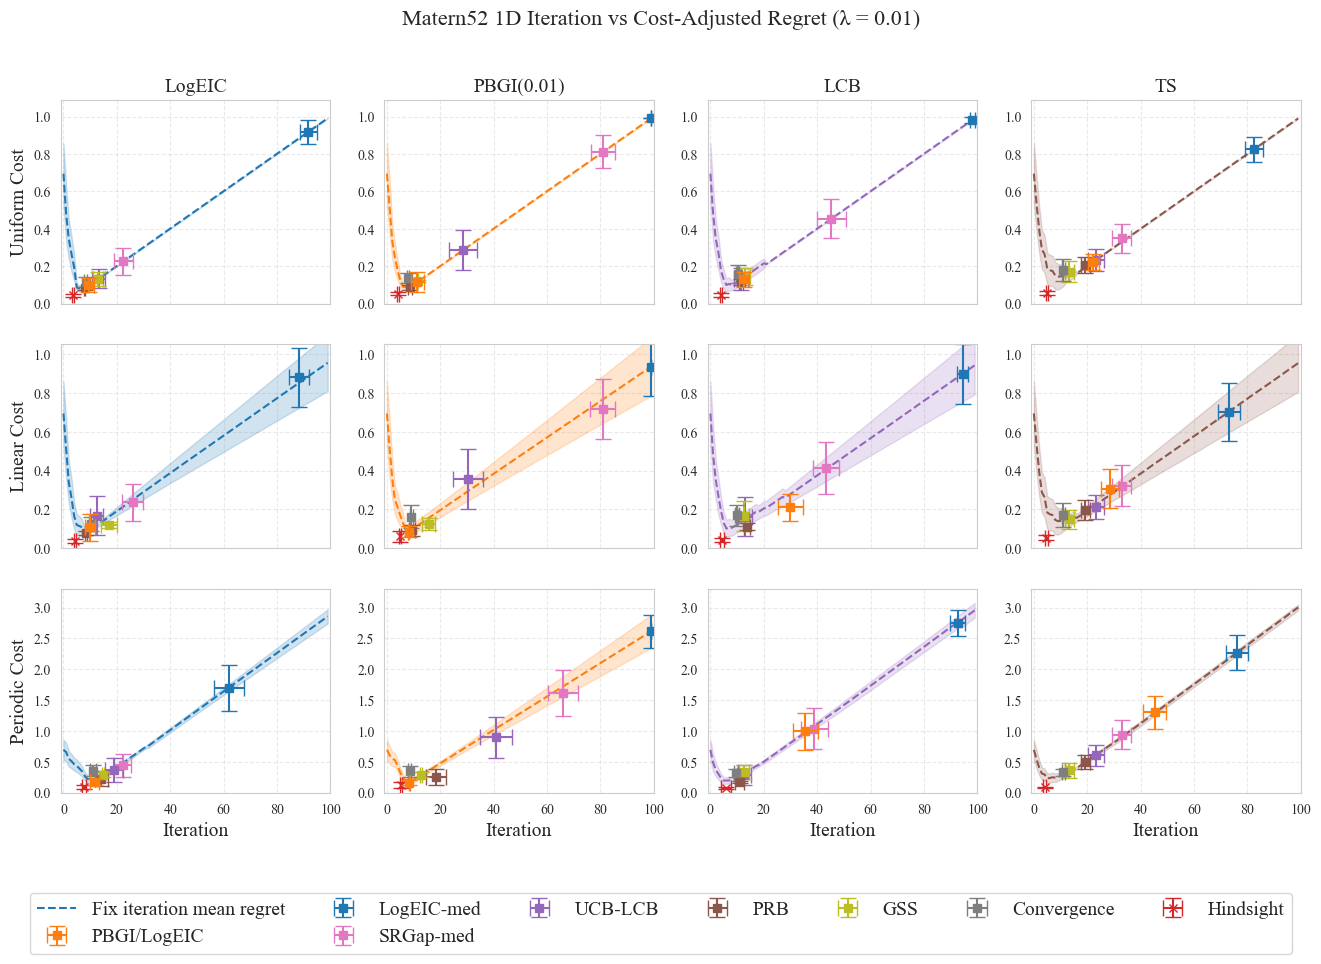

limits: 0.006984903736290726, 0.69422729855084
limits: 0.006023906758414189, 0.69422729855084
limits: 0.011949465508333021, 0.69422729855084


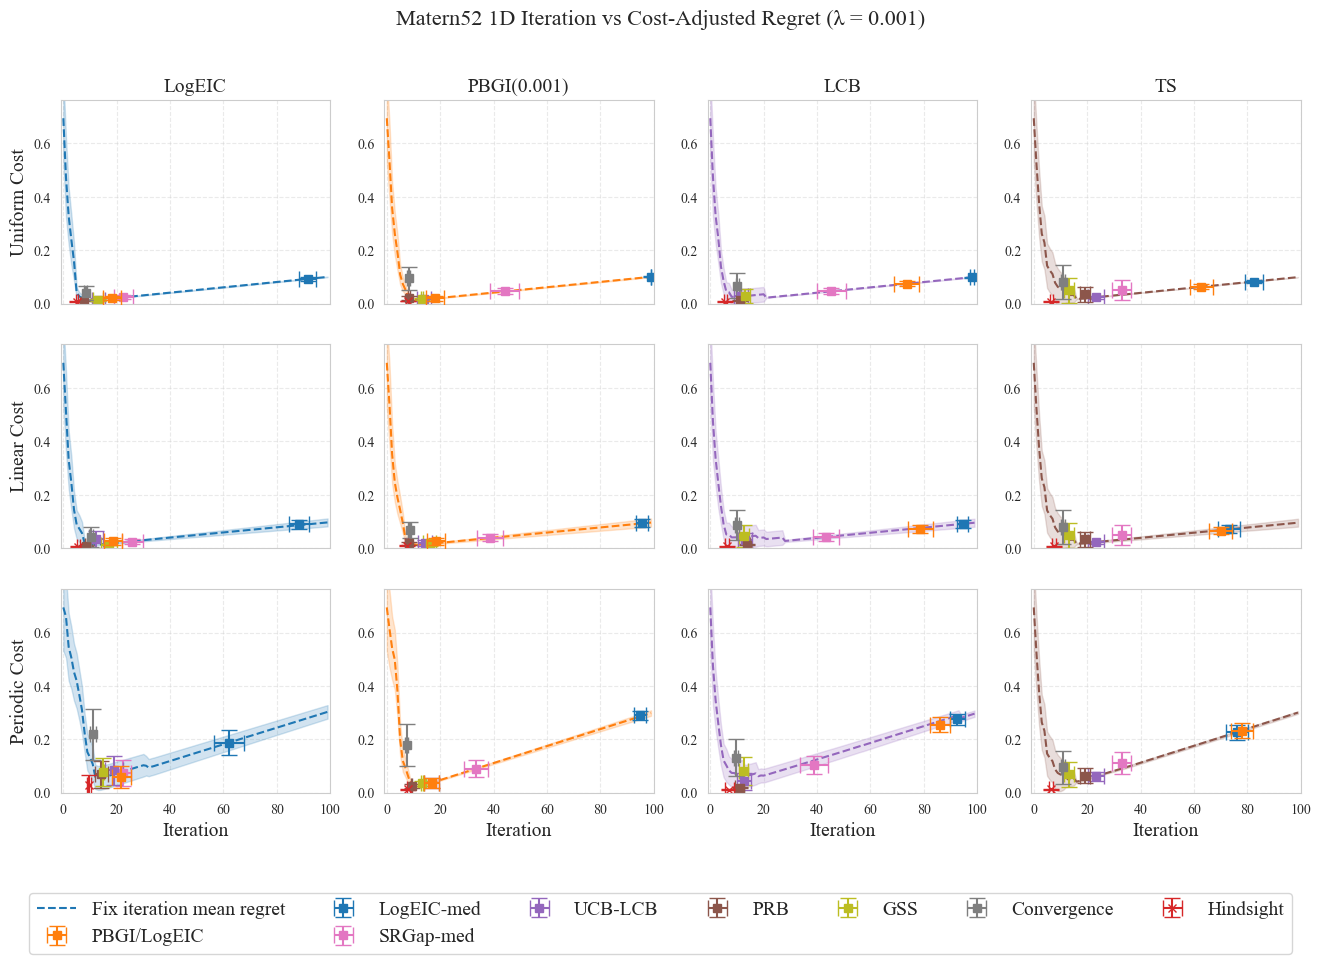

In [59]:
# build list of column settings
col_settings = list(itertools.product(cost_type))


l = 0.1 
for lmbda in lambda_per_acq:
    n_rows = len(col_settings)
    n_cols = len(acquisition_functions)-2

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 3 * n_rows),  # adjust per‐subplot size
        sharex=True, sharey=False
    )
    # ensure axes is always shape (n_rows, n_cols)
    axes = np.array(axes)
    if axes.ndim == 1:
        # if only one row, shape (n_cols,) → (1, n_cols)
        if n_rows == 1:
            axes = axes[np.newaxis, :]
        # if only one col, shape (n_rows,) → (n_rows, 1)
        else:
            axes = axes[:, np.newaxis]

    for row_idx, cost in enumerate(cost_type):
        max_y = 0
        min_y = 100
        for col_idx, a in enumerate(acquisition_functions):
            # print(a.split("_")[-1])
            if a.split("_")[0] == "Stable" and a.split("_")[-1] != lmbda_to_str[lmbda]:
                continue

            ax = axes[row_idx, acq_col_idxs[a]]

            metric_keys = [
                "cumulative cost",
                "best observed",
                "regret", 
                "StablePBGI(0.1) acq",
                "StablePBGI(0.01) acq",
                "StablePBGI(0.001) acq",
                "LogEIC acq", 
                "UCB-LCB acq", 
                "Regret-Gap acq", 
                "PRB_0.1"
            ]
            
            regret = np.array(metrics_per_acq[(a, l, cost)]['regret'])[:, :iteration_cutoff[lmbda]]
            cumulative_cost = np.array(metrics_per_acq[(a, l, cost)]["cumulative cost"])[:, :iteration_cutoff[lmbda]]
            LogEIC_acq = np.array(metrics_per_acq[(a, l, cost)]["LogEIC acq"])[:, :iteration_cutoff[lmbda]]
            UCB_LCB_acq = np.array(metrics_per_acq[(a, l, cost)]["UCB-LCB acq"])[:, :iteration_cutoff[lmbda]]
            PRB_0_1_acq = np.array(metrics_per_acq[(a, l, cost)]["PRB_0.1"])[:, :iteration_cutoff[lmbda]]
            RegretGap_acq = np.array(metrics_per_acq[(a, l, cost)]["Regret-Gap acq"])[:, :iteration_cutoff[lmbda]] 
            # current_best = np.array(current_best_per_acq[(a, l)])[:, :iteration_cutoff]
            best_observed = np.array(metrics_per_acq[(a, l, cost)]["best observed"])[:, :iteration_cutoff[lmbda]]

            # Compute cost-adjusted regret curve
            cost_adjusted_regret = regret + lmbda * cumulative_cost

            # Compute stopping point, which is the first time acq < best observed 
            stopping_times = {}
            stopping_cost_adjusted_regrets = {}
            for stopping_rule in stopping_rules: 
                stopping_cost_adjusted_regrets[stopping_rule] = []
                stopping_times[stopping_rule] = []
            
            hindsight_best_times = []
            hindsight_best_regrets = []

            n_seeds = regret.shape[0]

            for seed_idx in range(n_seeds):
                best_obs_seed = best_observed[seed_idx]
                stopping_indices = return_stopping_indices(
                    best_obs_seed=best_obs_seed,
                    LogEIC_seed=LogEIC_acq[seed_idx],
                    UCB_LCB_seed=UCB_LCB_acq[seed_idx],
                    PRB_seed=PRB_0_1_acq[seed_idx],
                    RegretGap_seed=RegretGap_acq[seed_idx],
                    lmbda=lmbda,
                    max_iter=iteration_cutoff[lmbda],
                    ucb_lcb_threshold=ucb_lcb_threshold,
                    delta=delta,
                    convergence_window=convergence_window,
                    gss_window=gss_window,
                    gss_frac=gss_frac
                )

                for stopping_rule in stopping_rules:
                    i_stop = stopping_indices[stopping_rule]
                    stopping_times[stopping_rule].append(stopping_indices[stopping_rule])
                    cost_adj_regret_at_stop = cost_adjusted_regret[seed_idx, i_stop]
                    stopping_cost_adjusted_regrets[stopping_rule].append(cost_adj_regret_at_stop)

                i_best = np.argmin(cost_adjusted_regret[seed_idx])
                hindsight_best_times.append(i_best)
                hindsight_best_regrets.append(cost_adjusted_regret[seed_idx, i_best])
        
            # Convert to arrays
            for stopping_rule in stopping_rules:
                stopping_times[stopping_rule] = np.array(stopping_times[stopping_rule])
                stopping_cost_adjusted_regrets[stopping_rule] = np.array(stopping_cost_adjusted_regrets[stopping_rule])
            
            # Compute and plot mean curve and fill error bars for fixed iteration stopping 
            mean_curve, stderr_curve = mean_and_std(cost_adjusted_regret, cost_adjusted_regret.shape[0])

            x = np.arange(len(mean_curve))
            ax.plot(mean_curve, label='Fix iteration mean regret', linestyle='--', color=color_dict[a], zorder=1)
            ax.fill_between(np.arange(len(mean_curve)), 
                            mean_curve - 2*stderr_curve,
                            mean_curve + 2*stderr_curve, 
                            color=color_dict[a],
                            alpha=0.2, zorder=1)
            
            
            # plot stopping time and cost adjusted regret for each stopping rule 
            for rule in stopping_rules:
                mt,ms = mean_and_std(stopping_times[rule], n_seeds) 
                et,es = mean_and_std(stopping_cost_adjusted_regrets[rule], n_seeds)
                if rule == 'LogEIC':
                    zorder=3
                else:
                    zorder=2
                ax.errorbar(mt, et, xerr=ms, yerr=2*es,
                            fmt='s', color=color_dict[rule], capsize=6, label=name_dict[rule], zorder=zorder)
            
            mean_hindsight_time, stderr_hindsight_time = mean_and_std(hindsight_best_times, n_seeds)
            mean_hindsight_regret, stderr_hindsight_regret = mean_and_std(hindsight_best_regrets, n_seeds) 
            
            ax.errorbar(mean_hindsight_time,
                                mean_hindsight_regret,
                                xerr=stderr_hindsight_time,
                                yerr=2*stderr_hindsight_regret,
                                fmt='x', color=color_dict['Hindsight'], capsize=6, label='Hindsight')

            # title only on top row, y‐label only on first column
            if (row_idx == 0):
                ax.set_title(f'{name_dict[a]}',fontsize=14)
            elif (row_idx == 2): 
                ax.set_xlabel("Iteration", fontsize=14)
                # ax.set_title(f'λ={lmbda}, cost={cost}')
            if acq_col_idxs[a] == 0:
                ax.set_ylabel(name_dict[cost], fontsize=14)
            
            ax.grid(True, linestyle='--', alpha=0.4)
            
            for rule in stopping_rules:
                max_y = max(max_y, mean_curve.max())
                min_y = min(min_y, min(mean_curve.min(), mean_hindsight_regret.min()))
        print(f"limits: {min_y}, {max_y}")
        for col_idx in range(4):
            axes[row_idx, col_idx].set_ylim(0, max_y*1.1)
            axes[row_idx, col_idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    
    # one legend for entire figure
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='lower center',
               bbox_to_anchor=(0.5, -0.08),
               ncol=len(stopping_rules),
               fontsize=14)

    fig.suptitle(f'{kernel} 1D Iteration vs Cost-Adjusted Regret (λ = {lmbda})', fontsize=16)
    # plt.tight_layout(rect=[0, 0.0, 1, 0.95])
    plt.xlim(-1, iteration_cutoff[lmbda])
    plt.savefig(f'../plots/{kernel}_1D_{lmbda_to_str[lmbda]}.png', bbox_inches='tight')
    plt.show()


Plots: only showing cost-adjusted regret 


limits: 0, 10.009102693924566
['LogEIC', 'PBGI', 'LCB', 'TS']
limits: 0, 0.991327880867878
['LogEIC', 'PBGI', 'LCB', 'TS']
limits: 0, 0.11637995920820267
['LogEIC', 'PBGI', 'LCB', 'TS']


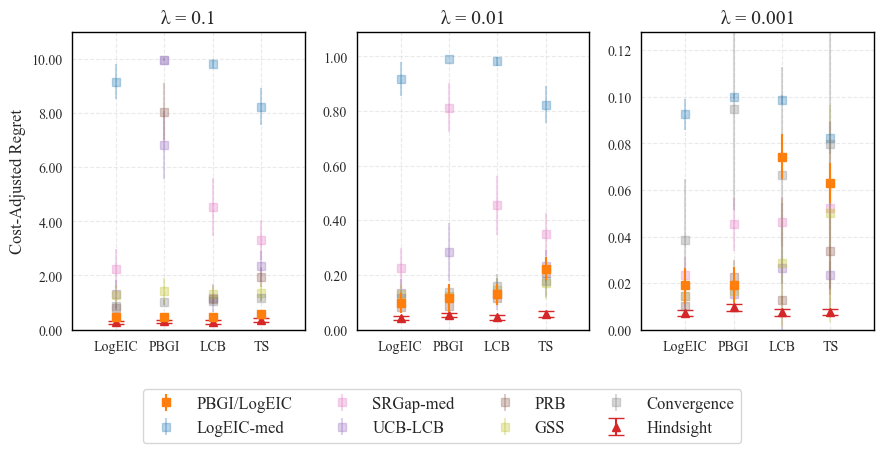

limits: 0, 9.751537215344449
['LogEIC', 'PBGI', 'LCB', 'TS']
limits: 0, 1.0103656389426803
['LogEIC', 'PBGI', 'LCB', 'TS']
limits: 0, 0.11454823305701448
['LogEIC', 'PBGI', 'LCB', 'TS']


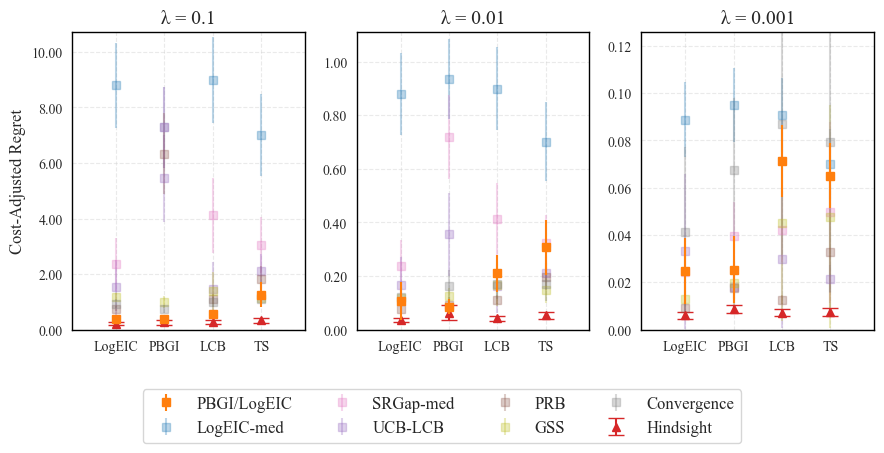

limits: 0, 28.5148134094394
['LogEIC', 'PBGI', 'LCB', 'TS']
limits: 0, 2.852134697348787
['LogEIC', 'PBGI', 'LCB', 'TS']
limits: 0, 0.2979304416143904
['LogEIC', 'PBGI', 'LCB', 'TS']


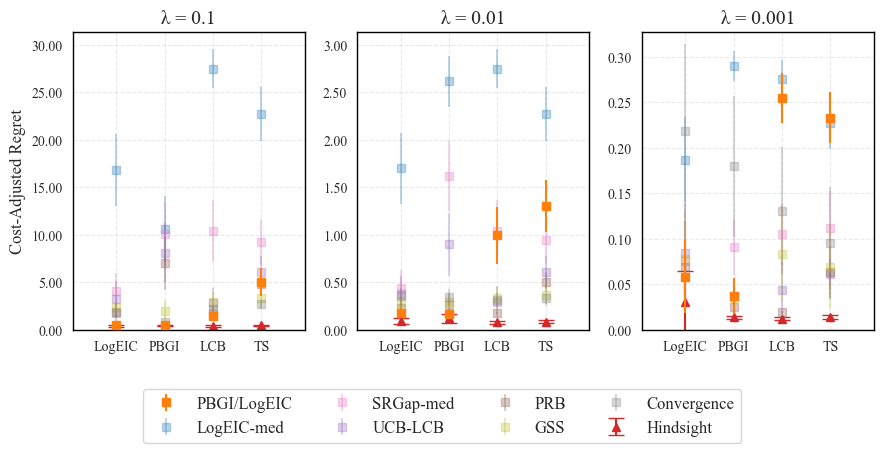

In [61]:
l = 0.1

def style_spines(ax, color='black', linewidth=1):
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor(color)
        spine.set_linewidth(linewidth)


# build list of column settings
col_settings = list(itertools.product(cost_type))
n_rows = len(col_settings)
n_cols = len(acquisition_functions)-2


for cost in cost_type:
    # Hack by Ziv: transpose axes
    fig, axes = plt.subplots(
        1, n_rows, # n_rows, n_cols,
        figsize=(3 * n_rows, 4 * 1), # (4 * n_cols, 3 * n_rows),  # adjust per‐subplot size
        sharex=False, sharey=False
    )

    axes = axes.T
    # ensure axes is always shape (n_rows, n_cols)
    axes = np.array(axes)
    if axes.ndim == 1:
        # if only one row, shape (n_cols,) → (1, n_cols)
        if n_rows == 1:
            axes = axes[np.newaxis, :]
        # if only one col, shape (n_rows,) → (n_rows, 1)
        else:
            axes = axes[:, np.newaxis]
  
        
    
    for row_idx, lmbda in enumerate(lambda_per_acq):
        max_y = 0
        min_y = 100
        x_labels = [""] * n_cols
        for a in acquisition_functions: 
            if a.split("_")[0] == "Stable" and a.split("_")[-1] != lmbda_to_str[lmbda]:
                continue

            ax = axes[row_idx, 0] 
            col_idx = acq_col_idxs[a]
            x_labels[col_idx] = name_dict[a]

            metric_keys = [
                "cumulative cost",
                "best observed",
                "regret", 
                "StablePBGI(0.1) acq",
                "StablePBGI(0.01) acq",
                "StablePBGI(0.001) acq",
                "LogEIC acq", 
                "UCB-LCB acq", 
                "Regret-Gap acq", 
                "PRB_0.1"
            ]
            
            regret = np.array(metrics_per_acq[(a, l, cost)]['regret'])[:, :iteration_cutoff[lmbda]]
            cumulative_cost = np.array(metrics_per_acq[(a, l, cost)]["cumulative cost"])[:, :iteration_cutoff[lmbda]]
            LogEIC_acq = np.array(metrics_per_acq[(a, l, cost)]["LogEIC acq"])[:, :iteration_cutoff[lmbda]]
            UCB_LCB_acq = np.array(metrics_per_acq[(a, l, cost)]["UCB-LCB acq"])[:, :iteration_cutoff[lmbda]]
            PRB_0_1_acq = np.array(metrics_per_acq[(a, l, cost)]["PRB_0.1"])[:, :iteration_cutoff[lmbda]]
            RegretGap_acq = np.array(metrics_per_acq[(a, l, cost)]["Regret-Gap acq"])[:, :iteration_cutoff[lmbda]] 
            best_observed = np.array(metrics_per_acq[(a, l, cost)]["best observed"])[:, :iteration_cutoff[lmbda]]

            # Compute cost-adjusted regret curve
            cost_adjusted_regret = regret + lmbda * cumulative_cost

            #Compute stopping point, which is the first time acq < best observed 
            stopping_times = {}
            stopping_cost_adjusted_regrets = {}
            for stopping_rule in stopping_rules: 
                stopping_cost_adjusted_regrets[stopping_rule] = []
                stopping_times[stopping_rule] = []
            
            hindsight_best_times = []
            hindsight_best_regrets = []

            n_seeds = regret.shape[0]

            for seed_idx in range(n_seeds):
                best_obs_seed = best_observed[seed_idx]
                stopping_indices = return_stopping_indices(
                    best_obs_seed=best_obs_seed,
                    LogEIC_seed=LogEIC_acq[seed_idx],
                    UCB_LCB_seed=UCB_LCB_acq[seed_idx],
                    PRB_seed=PRB_0_1_acq[seed_idx],
                    RegretGap_seed=RegretGap_acq[seed_idx],
                    lmbda=lmbda,
                    max_iter=iteration_cutoff[lmbda],
                    ucb_lcb_threshold=ucb_lcb_threshold,
                    delta=delta,
                    convergence_window=convergence_window,
                    gss_window=gss_window,
                    gss_frac=gss_frac
                )

                for stopping_rule in stopping_rules:
                    i_stop = stopping_indices[stopping_rule]
                    stopping_times[stopping_rule].append(stopping_indices[stopping_rule])
                    cost_adj_regret_at_stop = cost_adjusted_regret[seed_idx, i_stop]
                    stopping_cost_adjusted_regrets[stopping_rule].append(cost_adj_regret_at_stop)

                i_best = np.argmin(cost_adjusted_regret[seed_idx])
                hindsight_best_times.append(i_best)
                hindsight_best_regrets.append(cost_adjusted_regret[seed_idx, i_best])
        
            # Convert to arrays
            for stopping_rule in stopping_rules:
                stopping_times[stopping_rule] = np.array(stopping_times[stopping_rule])
                stopping_cost_adjusted_regrets[stopping_rule] = np.array(stopping_cost_adjusted_regrets[stopping_rule])
        
            # Plot cost adjusted simple regret of different stopping rules, on the same axis 
            for i, rule in enumerate(stopping_rules):
                mt,ms = mean_and_std(stopping_times[rule], n_seeds) 
                et,es = mean_and_std(stopping_cost_adjusted_regrets[rule], n_seeds)
                max_y = max(max_y, et + es)
                if rule == 'LogEIC':
                    zorder=3
                    alpha = 1.0
                else:
                    zorder=2
                    alpha = 0.3
                ax.errorbar(col_idx,
                            et,
                            yerr=2*es,
                            fmt='s', color=color_dict[rule], capsize=0, label=name_dict[rule], zorder=zorder, alpha=alpha)
            
            mean_hindsight_time, stderr_hindsight_time = mean_and_std(hindsight_best_times, n_seeds)
            mean_hindsight_regret, stderr_hindsight_regret = mean_and_std(hindsight_best_regrets, n_seeds) 
            
            ax.errorbar(col_idx, 
                        mean_hindsight_regret,
                        yerr=2*stderr_hindsight_regret,
                        fmt='^', color=color_dict['Hindsight'], capsize=6, label='Hindsight')
            
        print(f"limits: {0}, {max_y}")

        ax.set_title(name_dict[lmbda], fontsize=14)
        
        ax.set_ylim(0, max_y*1.1)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        ax.set_xlim(-0.9, n_cols - 0.1)
        x_labels = [name.split('(')[0] for name in x_labels]
        print(x_labels)
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels)
        ax.set_xticks([x + 0.5 for x in range(-1, n_cols)], minor=True)
        ax.grid(which='major', linestyle='--', alpha=0.4)
        ax.grid(which='minor', visible=False)
        ax.set_ylabel("Cost-Adjusted Regret" if row_idx == 0 else "")
        
        style_spines(ax)

    # one legend for entire figure
    handles, labels = axes[0,0].get_legend_handles_labels()
    legend_hls = dict(zip(labels, handles))
    fig.legend(legend_hls.values(), legend_hls.keys(), # handles, labels,
               loc='lower center',
               bbox_to_anchor=(0.5, -0.2),
               ncol=len(stopping_rules)/2 + 1,
               fontsize=12)
    
    plt.tight_layout(rect=[0, 0.0, 1, 0.95])
    plt.savefig(f'../plots/BarPlot_{kernel}_1D_{cost}.pdf', bbox_inches='tight')
    plt.show()